## O que extrair do grid:
        - Top 10 células mais densas. E detectar o motivo do ponto de interesse.
        - Hotsport das cidades
<img src='grid1.png' width="400" height="300">
<img src='grid2.png' width="445" height="178">

In [2]:
import csv
import sys
import math
import platform
import os.path
from datetime import datetime
from datetime import timedelta
from math import radians, cos, sin, asin, sqrt

In [3]:
import matplotlib.pyplot as plt
from scipy.stats.kde import gaussian_kde
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
if platform.system() == 'Linux':
    path = '/home/tulionpl/Repos/Pesquisa'
elif platform.system() == 'Windows':
    path = 'C:/Users/Tulio/Documents/Code/Pesquisa'
else:
    path = '/Users/tuliopolido/Repos/Pesquisa'

In [5]:
class Ponto:
    """A class that represents a certain point in the map at certain time"""
    def __init__(self,hora,coord):
        self.hora = hora
        self.coord = coord

    def __str__(self):
        return self.hora + " " + str(self.coord)

In [6]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r * 1000

In [7]:
def tempoDoisPontos(i, j, pontos):
    """Função para calcular o tempo entre dois pontos

    Argumentos:
    i -- Posição do primeiro ponto
    j -- Posição do segundo ponto
    pontos -- lista de pontos
    """

    ponto1 = pontos[i]
    ponto2 = pontos[j]
    pointTime = ponto1.hora
    pointTime = datetime.strptime(pointTime, '%Y-%m-%d %H:%M:%S')
    pointTime2 = ponto2.hora
    pointTime2 = datetime.strptime(pointTime2, '%Y-%m-%d %H:%M:%S')

    tempo = pointTime2-pointTime

    return tempo

In [8]:
def distDoisPontos(i, j, pontos):
    """Função para calcular a distância entre dois pontos"""

    dist = 0

    for k in range(i, j):
        point1 = pontos[k]
        point2 = pontos[k+1]

        pointCoord1 = point1.coord
        pointCoord2 = point2.coord

        dist += haversine(pointCoord1[0],
                                 pointCoord1[1], pointCoord2[0], pointCoord2[1])

    return dist

In [9]:
def lerDublin():
    pontos = {}
    keys = []
    allTimeGaps = []
    allCoordGaps = []
    timeGapsDiscrete = []
    coordGapsDiscrete = []

    # Opening the CSV data and dropping columns that are not used
    df = pd.read_csv(path+"/data/siri.20130101.csv")
    df = df.drop(['line ID', 'direction', 'journey pattern ID', 'timeframe', 
                'operator', 'delay', 'block ID', 'stop ID'], axis = 1)

    # Drop null journeys
    df = df.dropna()

    limits = (min(df.long),max(df.long),min(df.lat),max(df.lat))
    
    # Sorting the dataframe and reindexing
    df_ordinated = df.sort_values(['vehicle ID','Timestamp'])
    df_ordinated.index = range(len(df_ordinated))
    # df_ordinated['Timestamp'] = pd.to_datetime(df_ordinated['Timestamp'],unit='us')

    # Each unique vehicle ID becomes a key 
    keys = df_ordinated['vehicle ID'].unique()
    keys = list(map(str, keys)).copy()
    keys = list(map(str.strip, keys)).copy()

    # Initializing points and
    for key in keys:
        pontos[key] = []

    # Creating the points
    for index, row in df_ordinated.iterrows():
        crds = (row[3],row[4])

        hrs = datetime.fromtimestamp(row[0]/1000000)
        hrs = hrs.strftime("%Y-%m-%d %H:%M:%S")

        newInstance = Ponto(hrs,crds)
        pontos[str(int(row[5]))].append(newInstance)

    # Calculate the time and coord gaps

    for key in keys:
        for i in range(0,len(pontos[key])-1): 
            hr = tempoDoisPontos(i,i+1,pontos[key])
            hr = hr.total_seconds()
            allTimeGaps.append(hr)
            dist = distDoisPontos(i,i+1,pontos[key])
            allCoordGaps.append(dist)

    timeGapsDiscrete = list(map(int, allTimeGaps)).copy()
    coordGapsDiscrete = list(map(int, allCoordGaps)).copy()

    return allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos, limits
    
allTimeGaps, allCoordGaps, timeGapsDiscrete, coordGapsDiscrete, keys, pontos,limits = lerDublin()

In [10]:
class Grid:
    """A class that represents a grid in a city"""

    def __init__(self, height=100, width=100):
        """Contructor"""
        self.grid = {}
        self.height = height
        self.width = width
        self.limits = (0,0,0,0)
        self.center = (0,0)
        self.incrementX = 0
        self.incrementY = 0
        self.qtdX = 0
        self.qtdY = 0

    def __str__(self):
        """Returns the string form of the grid(dictionary)"""
        return str(self.grid)

    def createGrid(self,Xi,Xf,Yi,Yf):
        """Creates a grid based on the geographical limits recieved"""
        self.limits = (Xi,Xf,Yi,Yf)
        self.origin = (Xi,Yi)
        self.center = ( (Xf-Xi)/2 + Xi, (Yf-Yi)/2 + Yi)

        h = haversine(Xi,Yi,Xi,Yf) #height of grid in meters
        w = haversine(Xi,Yi,Xf,Yi) #width of grid in meters

        # Quantity of grid divisions
        self.qtdX = int(math.ceil(w/self.width)) 
        self.qtdY = int(math.ceil(h/self.height))

        # The increment on lat/long to each cell
        self.incrementX = (Xf - Xi)/ self.qtdX
        self.incrementY = (Yf - Yi)/ self.qtdY

    def addPoint(self,point):
        """Adds a point to the grid inside the respective cell"""
        added = True
        if point.coord[0] >= self.limits[0] and \
            point.coord[0] <= self.limits[1] and \
            point.coord[1] >= self.limits[2] and \
            point.coord[1] <= self.limits[3]:

            # Calculate the relative position in the axis (0.0 to 1.0)
            relatPosX = (point.coord[0]-self.limits[0])/(self.limits[1]-self.limits[0])
            relatPosY = (point.coord[1]-self.limits[2])/(self.limits[3]-self.limits[2])

            # Calculate how many incrementations should be made
            xInc = int( relatPosX * self.qtdX )
            yInc = int( relatPosY * self.qtdY )

            #Calculate the Latitude and Longitude
            Long = xInc * self.incrementX + self.origin[0]
            Lat = yInc * self.incrementY + self.origin[1]

            if not(Long >= self.limits[0] and Long <= self.limits[1] and Lat >= self.limits[2] and Lat <= self.limits[3]):    
                print(Long,Lat)

            if (Long,Lat) in self.grid:
                self.grid[(Long,Lat)].append(point)
            else:
                self.grid[(Long,Lat)] = []
                self.grid[(Long,Lat)].append(point)
        else:
            added = False
        
        return added

    def updateLimits(self, longMin,longMax,latMin,latMax):
        """Updates the geographical limits of the grid"""
        self.limits = (longMin,longMax,latMin,latMax)
        self.center = ((longMax-longMin)/2,(latMax-latMin)/2)

    def getMostDense(self,size=None):
        """Return the list of the most dense regions sorted and a list od their respective density"""
        higher = 0
        r = (0,0)
        listOfDensity = []
        listOfRegions = []

        for region in self.grid:
            listOfDensity.append(len(self.grid[region]))
            listOfRegions.append(region)

        listOfDensity, listOfRegions = zip(*sorted(zip(listOfDensity, listOfRegions),reverse=True))

        if(size != None and size > 0):
            listOfDensity = listOfDensity[:size]
            listOfRegions = listOfRegions[:size]

        return listOfDensity, listOfRegions

    def getMatrixUse(self):
        """Get the percentage of used cells in the grid"""

        iLong = self.origin[0]
        iLat = self.origin[1]
        used = 0
        total = 0
        for i in range(0,self.qtdX+1):
            for j in range(0,self.qtdY+1):
                    iLong = self.origin[0] + i*self.incrementX
                    iLat = self.origin[1]  + j*self.incrementY
                    total+=1
                    if (iLong,iLat) in self.grid:
                        used+=1

        return used, total, used/total

In [11]:
# Adiciona os pontos no grid de Dublin
grid = Grid()
grid.createGrid(limits[0],limits[1],limits[2],limits[3])

for key in keys:
    for pt in pontos[key]:
        grid.addPoint(pt)

In [12]:
listOfDensity, listOfRegions = grid.getMostDense(10)
print(listOfRegions)

((-6.257884840425532, 53.348801231155775), (-6.251907180851063, 53.33892301005025), (-6.259379255319149, 53.34520915075377), (-6.242940691489362, 53.427827), (-6.3923821808510635, 53.3937022361809), (-6.248918351063829, 53.27157150251256), (-6.136837234042553, 53.29492002512563), (-6.27880664893617, 53.41615273869346), (-6.257884840425532, 53.34520915075377), (-6.244435106382978, 53.427827))
(11936, 225446, 0.052943942230068396)


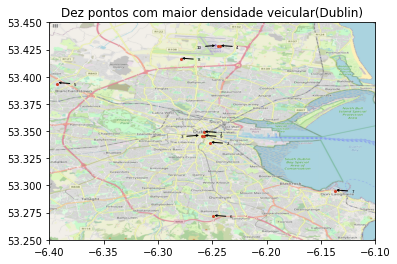

In [22]:
# Plota os 10 pontos com maior densidade veicular
longi = []
lati = []

for x,y in listOfRegions:
    longi.append(x)
    lati.append(y)

fig, ax = plt.subplots()
BBox = (-6.4,-6.1,53.25,53.45)
ruh_m = plt.imread(path+'/img/d1.png') #mapa a ser usado de fundo

ax.scatter(longi,lati,zorder=1, alpha=1, c='#d1432a', s=4,marker='o')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m,zorder=0, extent=BBox, aspect='equal')
ax.set_title('Dez pontos com maior densidade veicular(Dublin)')

offsetx = 0.01
offsety = 0.0012

for i in range(10):
    if(i == 2 or i == 9):
        offsetx = -0.02
    else:
        offsetx = 0.015
    plt.annotate(i+1, (longi[i]-0.001,lati[i]+0.001),xytext =(longi[i] +1 * offsetx, lati[i]-offsety), fontsize=4, arrowprops=dict(arrowstyle='->',facecolor='black'))

# plt.savefig(path+"/img/mapa10Densos_Dublin.png", dpi=300, transparent=False, facecolor='white')


In [14]:
def posOD():
    tripArrays = []
    ptsOrigem = []
    ptsDestino = []

    df = pd.read_csv("../data/siri.20130101.csv")
    df = df.sort_values(['vehicle ID', 'Timestamp'])

    # Drop null journeys
    df = df.dropna()

    ids = df['vehicle ID'].unique()

    # Getting unique trips for each id
    for id in ids:
        df_id = df.loc[df['vehicle ID'] == id]
        tripArrays.append(df_id['vehicle journey ID'].unique())

    for array in tripArrays:
        for trip in array:
            dftrip = df.loc[df['vehicle journey ID'] == trip]
            if len(dftrip) > 5:
                inicio = dftrip.index[0]
                fim = dftrip.index[-1]

                # Pegando pontos iniciais
                x = dftrip['long'][inicio]
                y = dftrip['lat'][inicio]
                t = datetime.fromtimestamp(dftrip['Timestamp'][inicio]/1000000)
                t = t.strftime("%Y-%m-%d %H:%M:%S")
                pt = Ponto(t,(x,y))
                ptsOrigem.append(pt)

                # Pegando pontos finais
                x = dftrip['long'][fim]
                y = dftrip['lat'][fim]
                t = datetime.fromtimestamp(dftrip['Timestamp'][fim]/1000000)
                t = t.strftime("%Y-%m-%d %H:%M:%S")
                pt = Ponto(t,(x,y))
                ptsDestino.append(pt)

    return ptsOrigem,ptsDestino

ptsOrigem,ptsDestino = posOD()

In [18]:
# Grid origem
gridO = Grid()
gridO.createGrid(limits[0],limits[1],limits[2],limits[3])

# Grid destino
gridD = Grid()
gridD.createGrid(limits[0],limits[1],limits[2],limits[3])

for i in range(len(ptsOrigem)):
    gridO.addPoint(ptsOrigem[i])
    gridD.addPoint(ptsDestino[i])

In [19]:
print(gridO.getMatrixUse())
print(gridD.getMatrixUse())
print(limits)

(619, 225446, 0.0027456685858254304)
(638, 225446, 0.002829945973758683)
(-6.61505, -6.05315, 53.070415, 53.606533)


In [14]:
# Testes com valores ficticios simples
grid2 = Grid()
grid2.createGrid(-100,100,-100,100)

pt = Ponto("13:30:30",(-0,-0))
pt2 = Ponto("13:50:12",(-100,-0))
pt3 = Ponto("13:50:12",(-0,-100))
pt4 = Ponto("13:50:12",(-100,-100))
pt5 = Ponto("13:50:12",(-50,-50))
pt6 = Ponto("13:50:12",(-60,-50))
pt7 = Ponto("13:50:12",(50,60))
pt8 = Ponto("13:50:12",(50,60))
pt9 = Ponto("13:50:12",(50,60))
pt10 = Ponto("13:50:12",(-0.001,-0.001))

grid2.addPoint(pt)
grid2.addPoint(pt2)
grid2.addPoint(pt3)
grid2.addPoint(pt4)
grid2.addPoint(pt5)
grid2.addPoint(pt6)
grid2.addPoint(pt7)
grid2.addPoint(pt8)
grid2.addPoint(pt9)
grid2.addPoint(pt10)

print(grid2.center)
print(grid2.getMostDense())
print(grid2.limits)
print(grid2.incrementX)
print(grid2.incrementY)

(0.0, 0.0)
((-0.009133254178479433, -0.0011241512657989006), 3)
(-100, 100, -100, 100)
0.009133254178463786
0.0011241512657943252
